# Bayesian Inference with information content model check for Langevin Equations

We will analyse single particle tracking data for a certain model of Langevin Equations. Now we want to see and verify how well the model fits the data.

## Description of the Model

The Model is described below.

The langevin equation is given by 

$$ \boxed{\frac{d\hat{x}(t)}{dt} = \mu(\hat{x}) f + k_BT\frac{\partial\mu(\hat{x})}{\partial t} + \sqrt{2Dk_BT\mu(\hat{x})}\hat{\xi}(t)} $$

where $$ \boxed{\mu(\hat{x}) = D_0 |\hat{x}|^\alpha} $$

The corresponding Euler-Maruyuma Equation is given as

$$ \boxed{x(t+dt) = x(t) +D_0  |x(t)|^\alpha dt + k_B T \left(\alpha D_0 |x(t)|^{\alpha -1} \dfrac{x(t)}{|x(t)|}\right) dt+\sqrt{2D_0 k_B T |x(t)|^\alpha dt}\hat{N}(t)} $$

where $$ \hat{N}(t) \sim Normal (0,1) $$

## Generating Datasets

We will be working on artificial datasets on which we will be performing Bayesian Inference to get the parameters which we do not know.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from numba import jit

In [3]:
# from the mu equation
D_0 = 0.2

# the initial starting point for the stochastic process
x_0 = 50

# MU = 0.1

#starting time for the process siumulation
t_0 = 0

#ending time for the process simulation
t_e = 100

#The alpha value in the mu equation
ALPHA_M = 1

# the value of f in the models given f=0(Free Model), and f=-0.3(pull Model) 
F_L = [0., -.3]

# the inverse of thermodynamic Beta set as k_BT = 1 for the paper.
k_BT =1

# no of steps
n = 100

# time step dt
DT = (t_e - t_0)/n

VAR_MN = [0, 0.5, 40]

In [4]:
@jit
def Model(num,t_end,F,D,ALPHA):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1)
        # The github code has values rounded to 3 values after the point
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y 

In [5]:
@jit
def Model2(num,t_end,F,D,ALPHA):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA)) * np.random.normal(0,DT)
        # The github code has values rounded to 3 values after the point
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y 

### $M_{clean}$ Model generation

These models do not take into account the measurement noise due to the instrument doing the collecting the SPT data.

#### $M_{clean, free}$ Model

Clean model with $f=0$

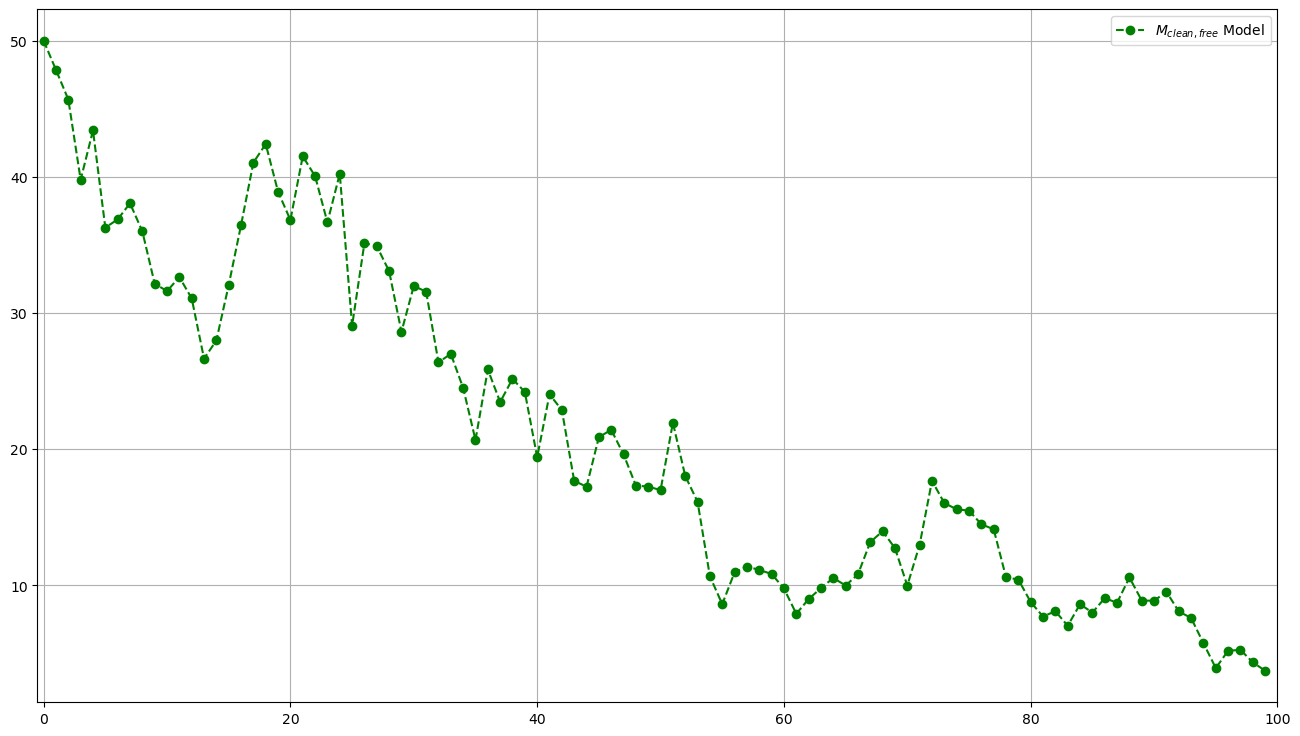

In [6]:
t_clean_free,x_clean_free = Model(n,t_e,F_L[0],D_0,ALPHA_M)

fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_clean_free,x_clean_free,'o--g',label = r"$M_{clean, free}$ Model")
axes.set_xlim((-0.5,100))
axes.legend()
axes.grid()

#### $M_{pull, free}$ Model

Clean model with $f=-0.3$

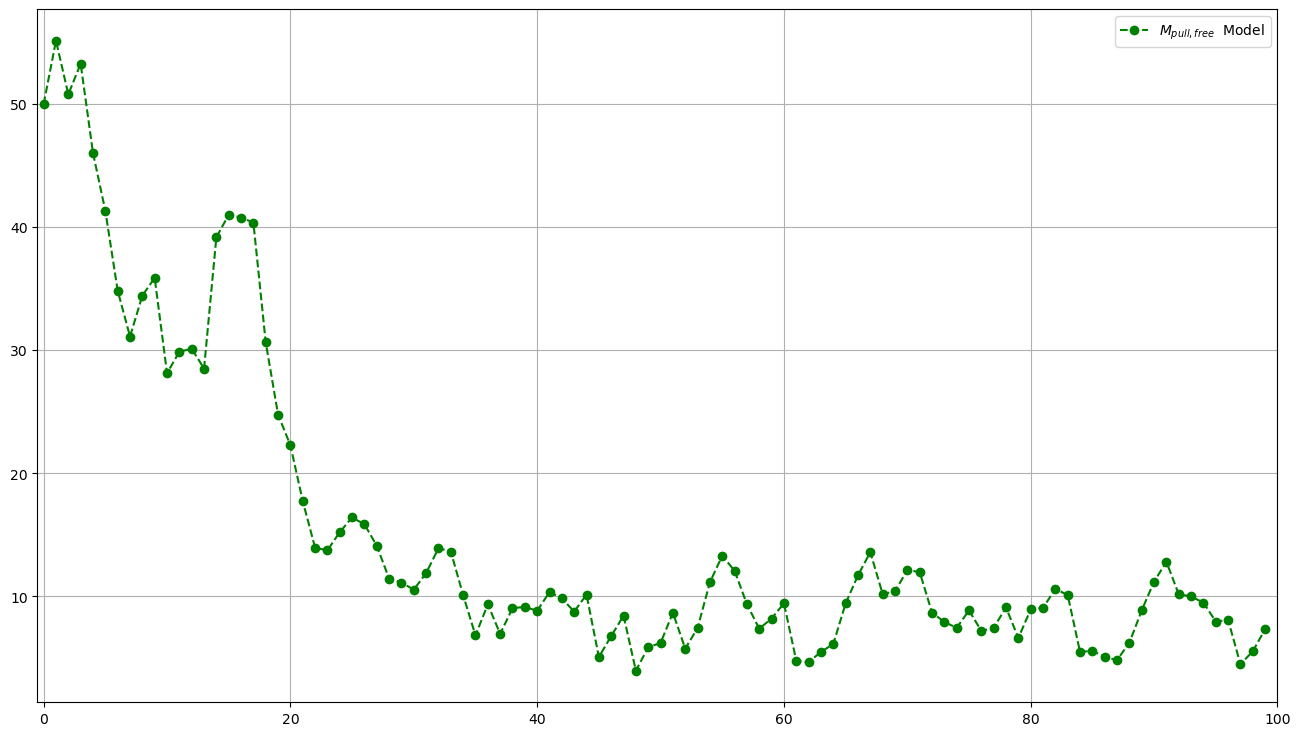

In [7]:
t_pull_free,x_pull_free = Model(n,t_e, F_L[1],D_0,ALPHA_M)
fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_pull_free,x_pull_free,'o--g',label = r"$M_{pull, free}$  Model")
axes.set_xlim((-0.5,100))
axes.legend()
axes.grid()   

### Measurement noise

In [8]:
@jit
def NoisyModel(num,t_end,F,D,ALPHA, VARN):
    y = np.zeros(num)
    ytrue = np.zeros(num)
    y[0] = x_0
    ytrue[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        ytrue[i+1] = ytrue[i] + D * (np.abs(ytrue[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(ytrue[i])**(ALPHA-1)*(ytrue[i]/(np.abs(ytrue[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(ytrue[i])**ALPHA) *  DT) * np.random.normal(0,1)
        y[i+1] = ytrue[i+1] + np.random.normal(0,np.sqrt(VARN))
    return t, y, ytrue

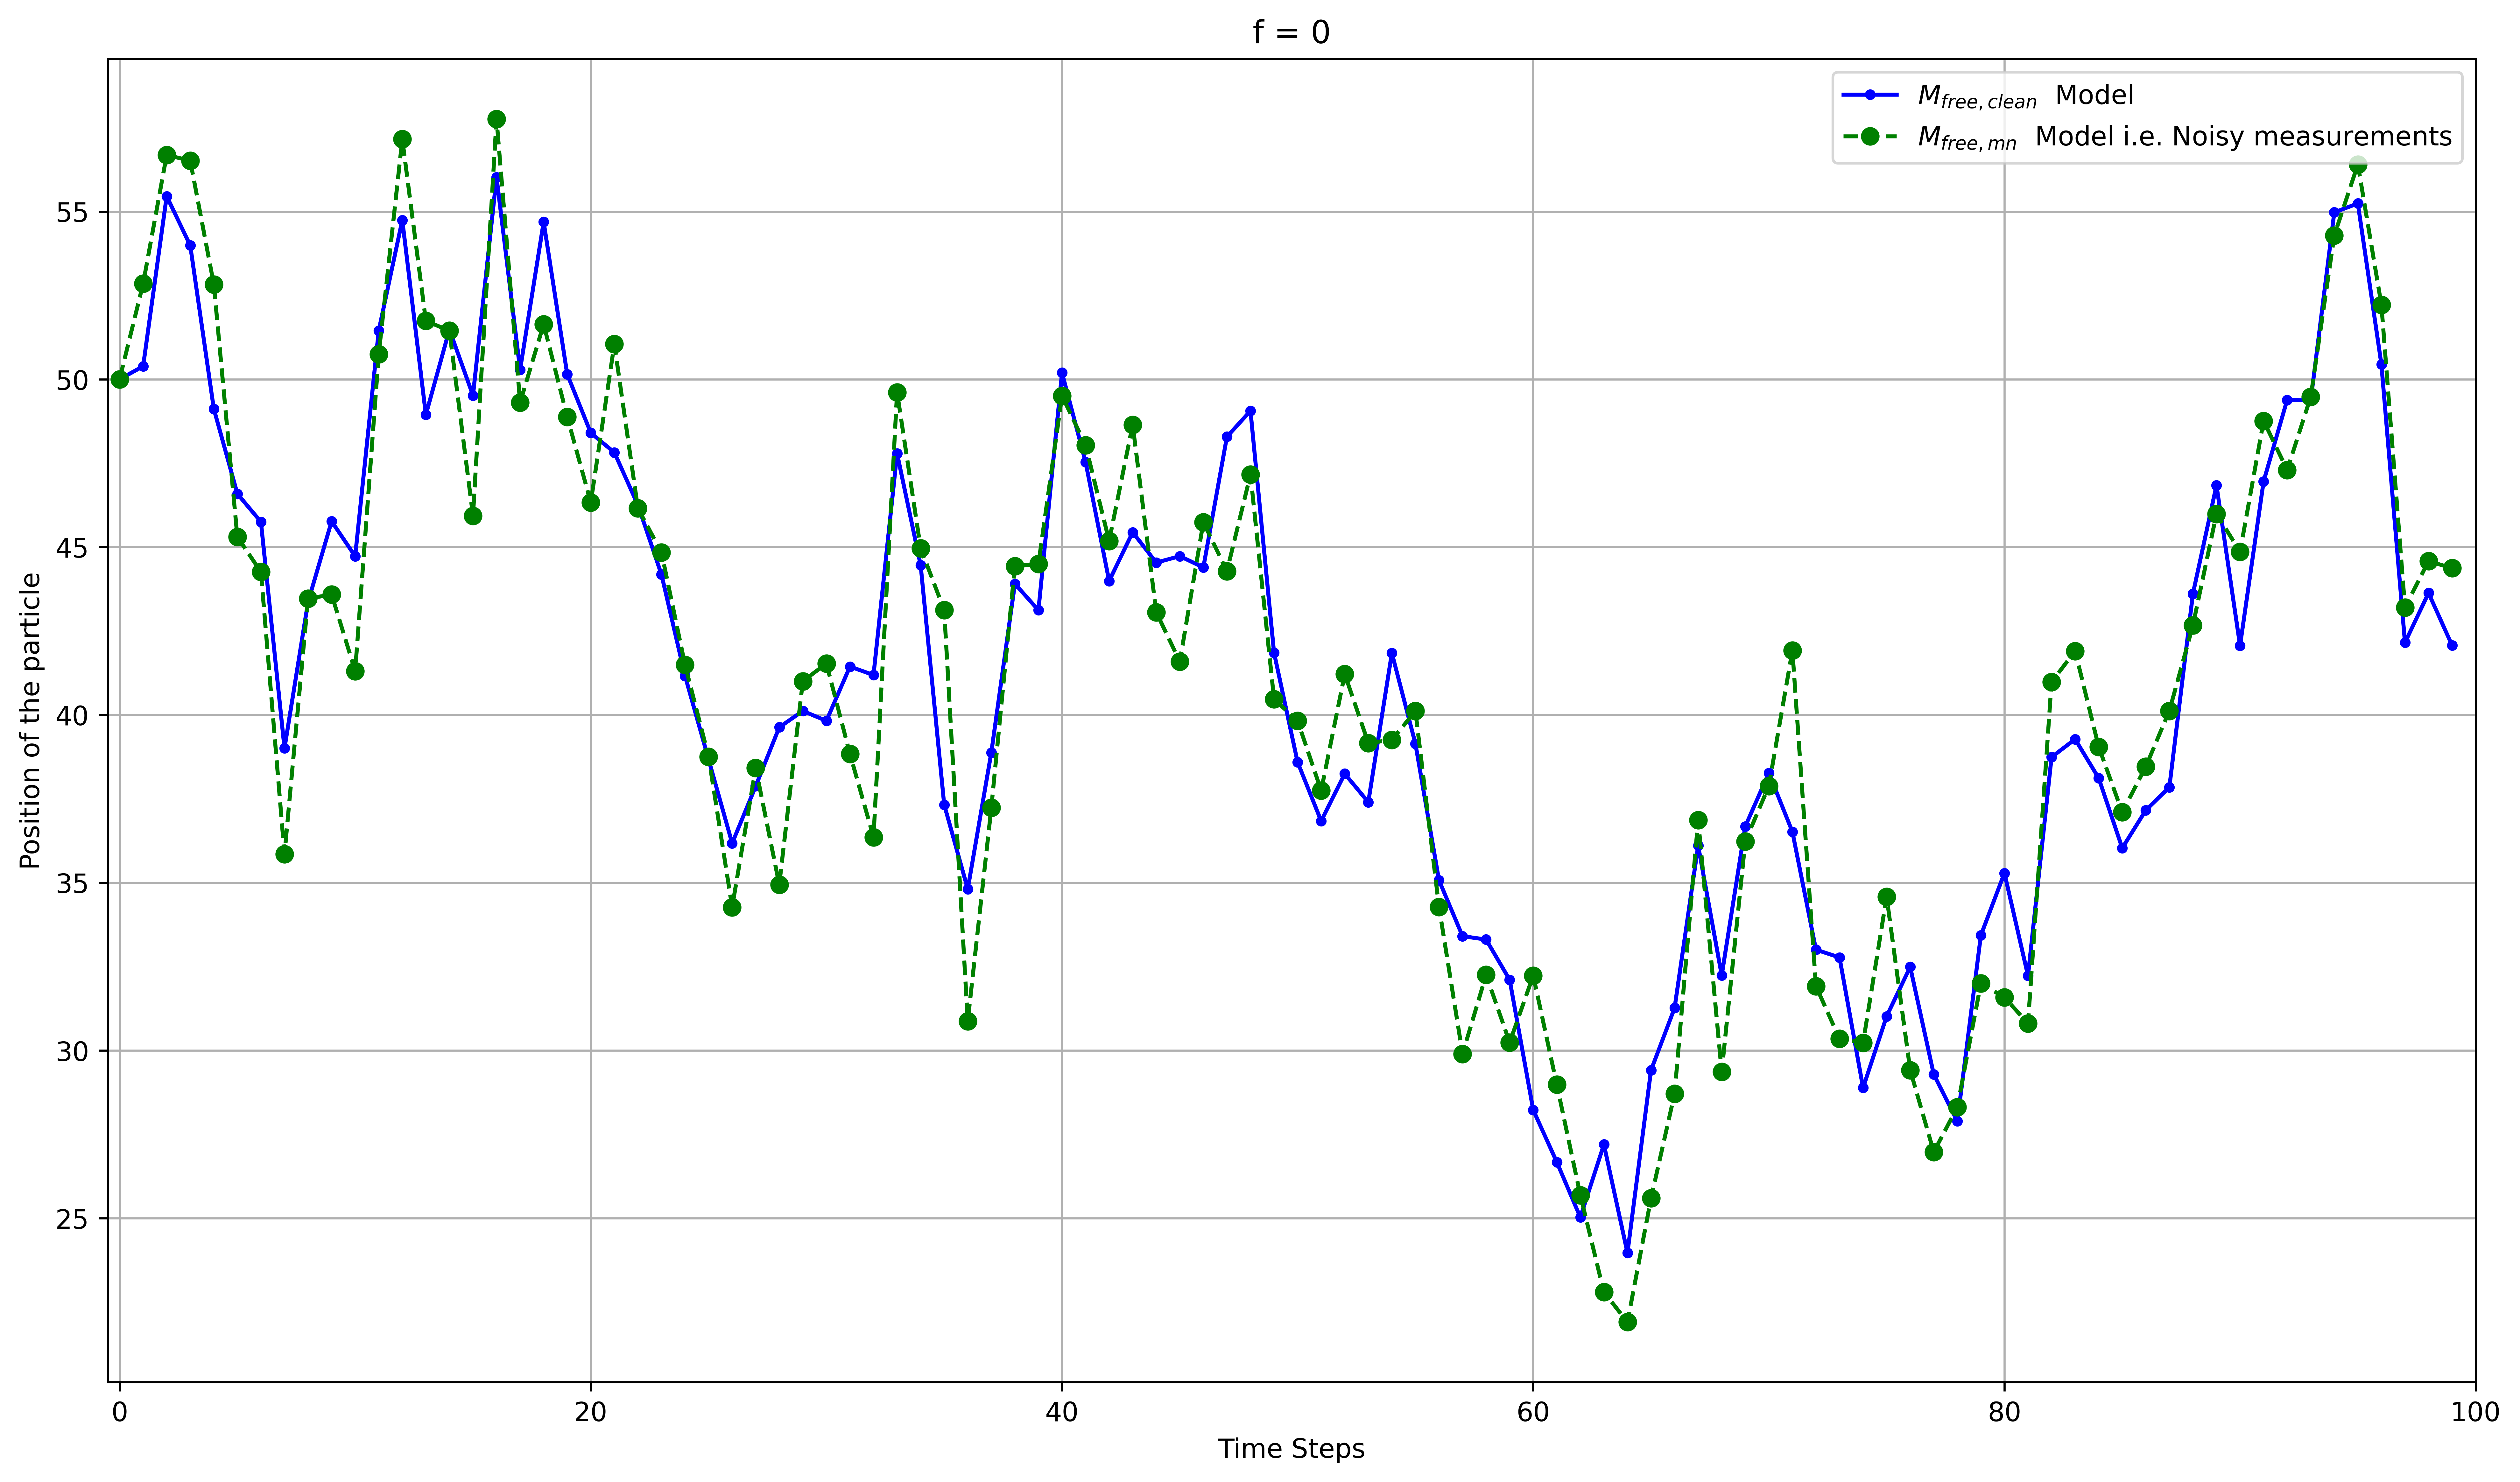

In [9]:
n=100
t_clean_mn, x_free_mn, x_clean_free = NoisyModel(n,t_e, F_L[0],D_0,ALPHA_M, 5)
# t_pull_mn, x_pull_mn, x_pull_free = NoisyModel(n,t_e, F_L[1],D_0,ALPHA_M, 5)

fig,axes = plt.subplots(1,1,figsize=(16,9), dpi = 600)
axes.plot(t_clean_mn, x_clean_free,'.-b',label = r"$M_{free, clean}$  Model")
axes.plot(t_clean_mn, x_free_mn,'o--g',label = r"$M_{free, mn}$  Model i.e. Noisy measurements")
# ax1].plot(t_pull_mn, x_pull_free,'.-b',label = r"$M_{pull, clean}$  Model")
# ax1].plot(t_pull_mn, x_pull_mn,'o--g',label = r"$M_{pull, mn}$  Model i.e. Noisy measurements")
axes.set_xlabel("Time Steps")
# ax1].set_xlabel("Time Steps")
axes.set_title(f"f = 0")
# ax1].set_title(f"f = %.1f"%F_L[1])
# axes.set_xticks(t_clean_mn), 
axes.set_xlim((-0.5,100))
axes.set_ylabel("Position of the particle")
# ax1].set_xlim((-0.5,100))
# ax1].set_ylabel("Position of the particle")
axes.legend()
axes.grid()
# axes[1].legend()
# axes[1].grid()

## Likelihood calculations of the datasets

$$ \boxed{P(\theta | D) = \Pi_{j=0}^{N} \frac{1}{\sqrt{2 \pi \sigma_j^2}} \exp\left(\frac{-(x_j - \langle x_j \rangle)^2)}{2 \sigma_j^2}\right)} $$

Where

$\sigma_i = 2  k_B  T  D  (\lvert x_{i-1} \rvert^\alpha)  dt$ and 

$  \langle x_i\rangle = x_{i-1} + \left( (\lvert x_{i-1} \rvert^\alpha)  f + k_B T (\alpha  D  (\lvert x_{i-1} \rvert^{\alpha-1}  (\text{sgn}(x_{i-1}))) \right)  dt $

In [10]:
@jit
def noisylikelihoodcalc(posn,DT,D,F,ALPHA, varmn):
    # time series
    n = len(posn)

    #init value
    logl = 0
    

    # Intial values of the variance mean both noisy and clean
    mob = D * (np.abs(posn[0]) ** ALPHA)
    std_dev_noise = 2 * mob * DT + 2 * varmn
    noisy_mean = posn[0] + (mob * F + k_BT * (ALPHA * D * ((np.abs(posn[0]) ** (ALPHA - 1)) * (np.sign(posn[0]))))) * DT
    
    # log likelihood at 1st step
    logl = logl - ((posn[1] - noisy_mean) ** 2) / (2 * std_dev_noise) - np.log(np.sqrt(2 * np.pi * std_dev_noise))
    
    for i in range(2,n):
        # Mobility at the step
        mob = D * np.abs(posn[i - 1]) ** ALPHA

        # clean variance at the jth step
        std_dev = 2 * mob * DT

        # clean mean position at the jth time step
        mean_dist = posn[i - 1] + (mob * F + ALPHA * D * (np.abs(posn[i - 1]) ** (ALPHA - 1)) * (np.sign(posn[i - 1]))) * DT

        # noisy mean position at the jth step
        noisy_mean = mean_dist - varmn/(std_dev_noise) * (posn[i-1] - noisy_mean)

        # noisy variance at the jth posn
        std_dev_noise = std_dev + varmn * (2 - varmn / std_dev_noise)

        # calculation of log likelihood
        logl = logl - ((posn[i] - noisy_mean) ** 2) / (2 * std_dev_noise) - 0.5 * np.log(2 * np.pi * std_dev_noise)
    
    return logl

In [10]:
p_data = [50.0,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926]

In [35]:
N = 1000
n = 100

# time step dt
DT = (t_e - t_0)/n

# log likelihood array initialization
logPROBD = np.zeros(N)
logPROBD1 = np.zeros(N)

logPROBA = np.zeros(N)
logPROBF = np.zeros(N)
logPROBMN = np.zeros(N)

alpha_range = np.linspace(0, 2, N)
d_range=np.linspace(0.001,1,N)
F_L_range=np.linspace(-1,1,N)
MN_range = np.linspace(0, 1, N)

varmntemp = 0
# p_data = [50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926]
# t_clean_free,xmeasured, xtrue = NoisyModel(n,t_e,F_L[1],D_0,ALPHA_M,varmntemp)
xmeasured = np.array(p_data)
# theta = [D_0, ALPHA_M,F_L[0], 10]
# varmntemp = VAR_MN[0]
# p_data = np.array([50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926])
# xmeasured = p_data
DT = 1

iD_0 =  0.150
iF = -0.287
ivarmn = 0.050
iALPHA_M = 1.047

varmntemp = ivarmn

for i in range(0,N):
    
    logPROBF[i] = noisylikelihoodcalc(xmeasured,DT,iD_0,F_L_range[i],iALPHA_M, varmntemp)

    logPROBD[i] = noisylikelihoodcalc(xmeasured,DT,d_range[i],iF,iALPHA_M, varmntemp)
    
    logPROBA[i] = noisylikelihoodcalc(xmeasured,DT,iD_0,F_L[1],alpha_range[i], varmntemp)
    
    logPROBMN[i] = noisylikelihoodcalc(xmeasured,DT,iD_0,iF,iALPHA_M, MN_range[i])

In [21]:
xdata = np.zeros(100)
xdata = np.round(xmeasured,3)
xdata,p_data

(array([50.   , 46.743, 46.751, 40.915, 45.066, 50.56 , 44.448, 40.518,
        40.145, 39.551, 42.887, 40.218, 44.399, 38.416, 36.626, 35.867,
        30.252, 28.843, 26.412, 27.815, 28.166, 32.899, 34.738, 33.237,
        24.448, 22.771, 19.285, 24.966, 23.912, 23.839, 23.83 , 22.253,
        15.661, 20.156, 20.166, 16.9  , 15.495, 18.734, 18.234, 17.823,
        16.052, 11.424,  9.422,  7.375,  7.255,  7.285,  6.737,  7.732,
         6.857,  7.034,  5.356,  3.797,  3.407,  4.365,  4.56 ,  4.888,
         3.802,  2.926,  3.57 ,  4.088,  2.347,  0.953,  1.723,  1.797,
         1.753,  2.165,  2.135,  2.404,  2.919,  1.197,  1.336,  1.428,
         1.848,  2.199,  1.101,  1.323,  0.716,  0.684,  0.898,  1.617,
         2.093,  2.412,  1.069,  1.278,  2.24 ,  0.303,  0.646, -0.443,
        -0.798, -0.821, -2.048, -1.683, -1.818, -1.309, -1.236, -1.823,
        -1.854, -2.183, -4.278, -4.293]),
 [50.0,
  46.743,
  46.751,
  40.915,
  45.066,
  50.56,
  44.448,
  40.518,
  40.145,
  39.55

In [105]:
X = np.zeros((100,100))
H = np.zeros(100)
DTH = 1*np.ones(100)


logZ = -183.617
for i in range(0,100):
    M = NoisyModel(100, 100, iF, iD_0, iALPHA_M, ivarmn)
    X[i] = M[1]
    H[i] = noisylikelihoodcalc(X[i], 1, iD_0, iF, iALPHA_M, ivarmn) - logZ
    # DTH[i][0] = H[i] 
X2 = np.array(X[:,0:100:2])
X3 = np.array(X[:,0:100:3])
X4 = np.array(X[:,0:100:4])
X5 = np.array(X[:,0:100:5])

H2 = noisylikelihoodcalc(X2, 2, iD_0, iF, iALPHA_M,ivarmn) - logZ
H3 = noisylikelihoodcalc(X2, 3, iD_0, iF, iALPHA_M,ivarmn) - logZ
H4 = noisylikelihoodcalc(X2, 4, iD_0, iF, iALPHA_M,ivarmn) - logZ
H5 = noisylikelihoodcalc(X2, 5, iD_0, iF, iALPHA_M,ivarmn) - logZ

DTH2 = 2*np.ones(len(H2))
DTH3 = 3*np.ones(len(H3))
DTH4 = 4*np.ones(len(H4))
DTH5 = 5*np.ones(len(H5))

# X2 = X2[:,2]
avgH = 2.86458
p = 0
for i in range(0,100):
    if H[i] > avgH :
        p += 1
    elif H[i] == avgH:
        p+=0.5
    else:
        p+=0
p = p/100
p

0.35

In [104]:
X[:,0:100:2].shape

(100, 50)

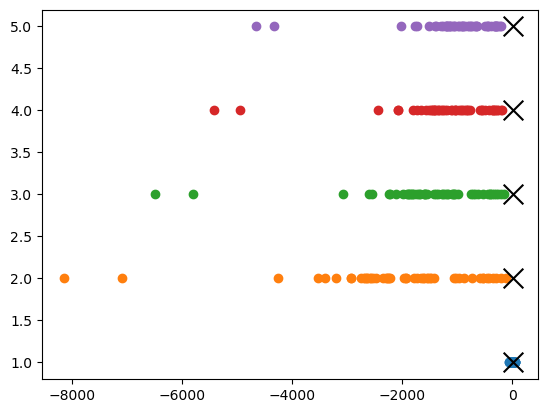

In [106]:
plt.scatter(H, DTH)
plt.scatter(H2, DTH2)
plt.scatter(H3, DTH3)
plt.scatter(H4, DTH4)
plt.scatter(H5, DTH5)
plt.scatter([avgH,avgH,avgH,avgH,avgH],[1,2,3,4,5],marker = "x", color = "k", s = 200)

In [203]:
Ndata = 1000
X = np.zeros((Ndata,100))
H = np.zeros(Ndata)
DTH = 1*np.ones(Ndata)


logZ = -181.638
iD_0 = 0.172
iF = -0.275
iALPHA_M = 0.998
for i in range(0,Ndata):
    M = NoisyModel(100, 100, iF, iD_0, iALPHA_M, 0)
    X[i] = M[1]
    H[i] = noisylikelihoodcalc(X[i], 1, iD_0, iF, iALPHA_M, 0) - logZ
    # DTH[i][0] = H[i] 
X2 = np.array(X[:,1:100:2])
X3 = np.array(X[:,1:100:3])
X4 = np.array(X[:,1:100:4])
X5 = np.array(X[:,1:100:5])

H2 = np.zeros(Ndata)
H3 = np.zeros(Ndata)
H4 = np.zeros(Ndata)
H5 = np.zeros(Ndata)
for i in range(0,Ndata):
    H2[i] = noisylikelihoodcalc(X2[i], 1, iD_0, iF, iALPHA_M,0) - logZ
    H3[i] = noisylikelihoodcalc(X3[i], 1, iD_0, iF, iALPHA_M,0) - logZ
    H4[i] = noisylikelihoodcalc(X4[i], 1, iD_0, iF, iALPHA_M,0) - logZ
    H5[i] = noisylikelihoodcalc(X5[i], 1, iD_0, iF, iALPHA_M,0) - logZ

DTH2 = 2*np.ones(Ndata)
DTH3 = 3*np.ones(Ndata)
DTH4 = 4*np.ones(Ndata)
DTH5 = 5*np.ones(Ndata)

# X2 = X2[:,2]
avgH = 1.78299
p = 0
for i in range(0,Ndata):
    if H3[i] > avgH :
        p += 1
    # elif H3[i] == avgH:
        # p+=0.5
    else:
        p+=0
p = p/len(H2)
p

0.99

In [187]:
np.round(X,3),np.round(X2,3)

(array([[50.   , 43.892, 40.827, ...,  2.735,  4.191,  4.447],
        [50.   , 38.04 , 44.169, ..., -3.214, -3.641, -3.926],
        [50.   , 47.208, 42.035, ...,  3.786,  0.814,  1.386],
        ...,
        [50.   , 43.797, 41.609, ..., -0.833, -0.497, -1.301],
        [50.   , 47.538, 47.241, ...,  3.502,  2.782,  4.548],
        [50.   , 46.754, 48.557, ...,  6.884,  8.367,  8.364]]),
 array([[43.892, 36.358, 31.191, ...,  2.36 ,  2.735,  4.447],
        [38.04 , 39.054, 40.499, ..., -2.608, -3.214, -3.926],
        [47.208, 39.583, 37.215, ...,  1.929,  3.786,  1.386],
        ...,
        [43.797, 37.8  , 37.091, ..., -0.181, -0.833, -1.301],
        [47.538, 38.932, 38.276, ...,  5.045,  3.502,  4.548],
        [46.754, 41.517, 41.749, ...,  4.762,  6.884,  8.364]]))

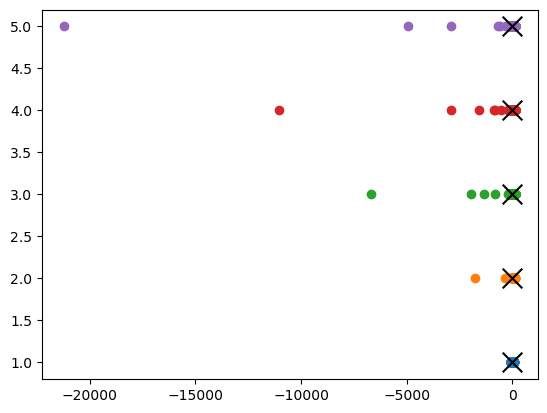

In [189]:
plt.scatter(H, DTH)
plt.scatter(H2, DTH2)
plt.scatter(H3, DTH3)
plt.scatter(H4, DTH4)
plt.scatter(H5, DTH5)
plt.scatter([avgH,avgH,avgH,avgH,avgH],[1,2,3,4,5],marker = "x", color = "k", s = 200)

In [79]:
plt.scatter?

Signature:
plt.scatter(
    x: 'float | ArrayLike',
    y: 'float | ArrayLike',
    s: 'float | ArrayLike | None' = None,
    c: 'ArrayLike | Sequence[ColorType] | ColorType | None' = None,
    marker: 'MarkerType | None' = None,
    cmap: 'str | Colormap | None' = None,
    norm: 'str | Normalize | None' = None,
    vmin: 'float | None' = None,
    vmax: 'float | None' = None,
    alpha: 'float | None' = None,
    linewidths: 'float | Sequence[float] | None' = None,
    *,
    edgecolors: "Literal['face', 'none'] | ColorType | Sequence[ColorType] | None" = None,
    plotnonfinite: 'bool' = False,
    data=None,
    **kwargs,
) -> 'PathCollection'
Docstring:
A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2 (typographic points are 1/72 in.).
    Default is ``rcParams['lines.markersize'] ** 2``.

    Th

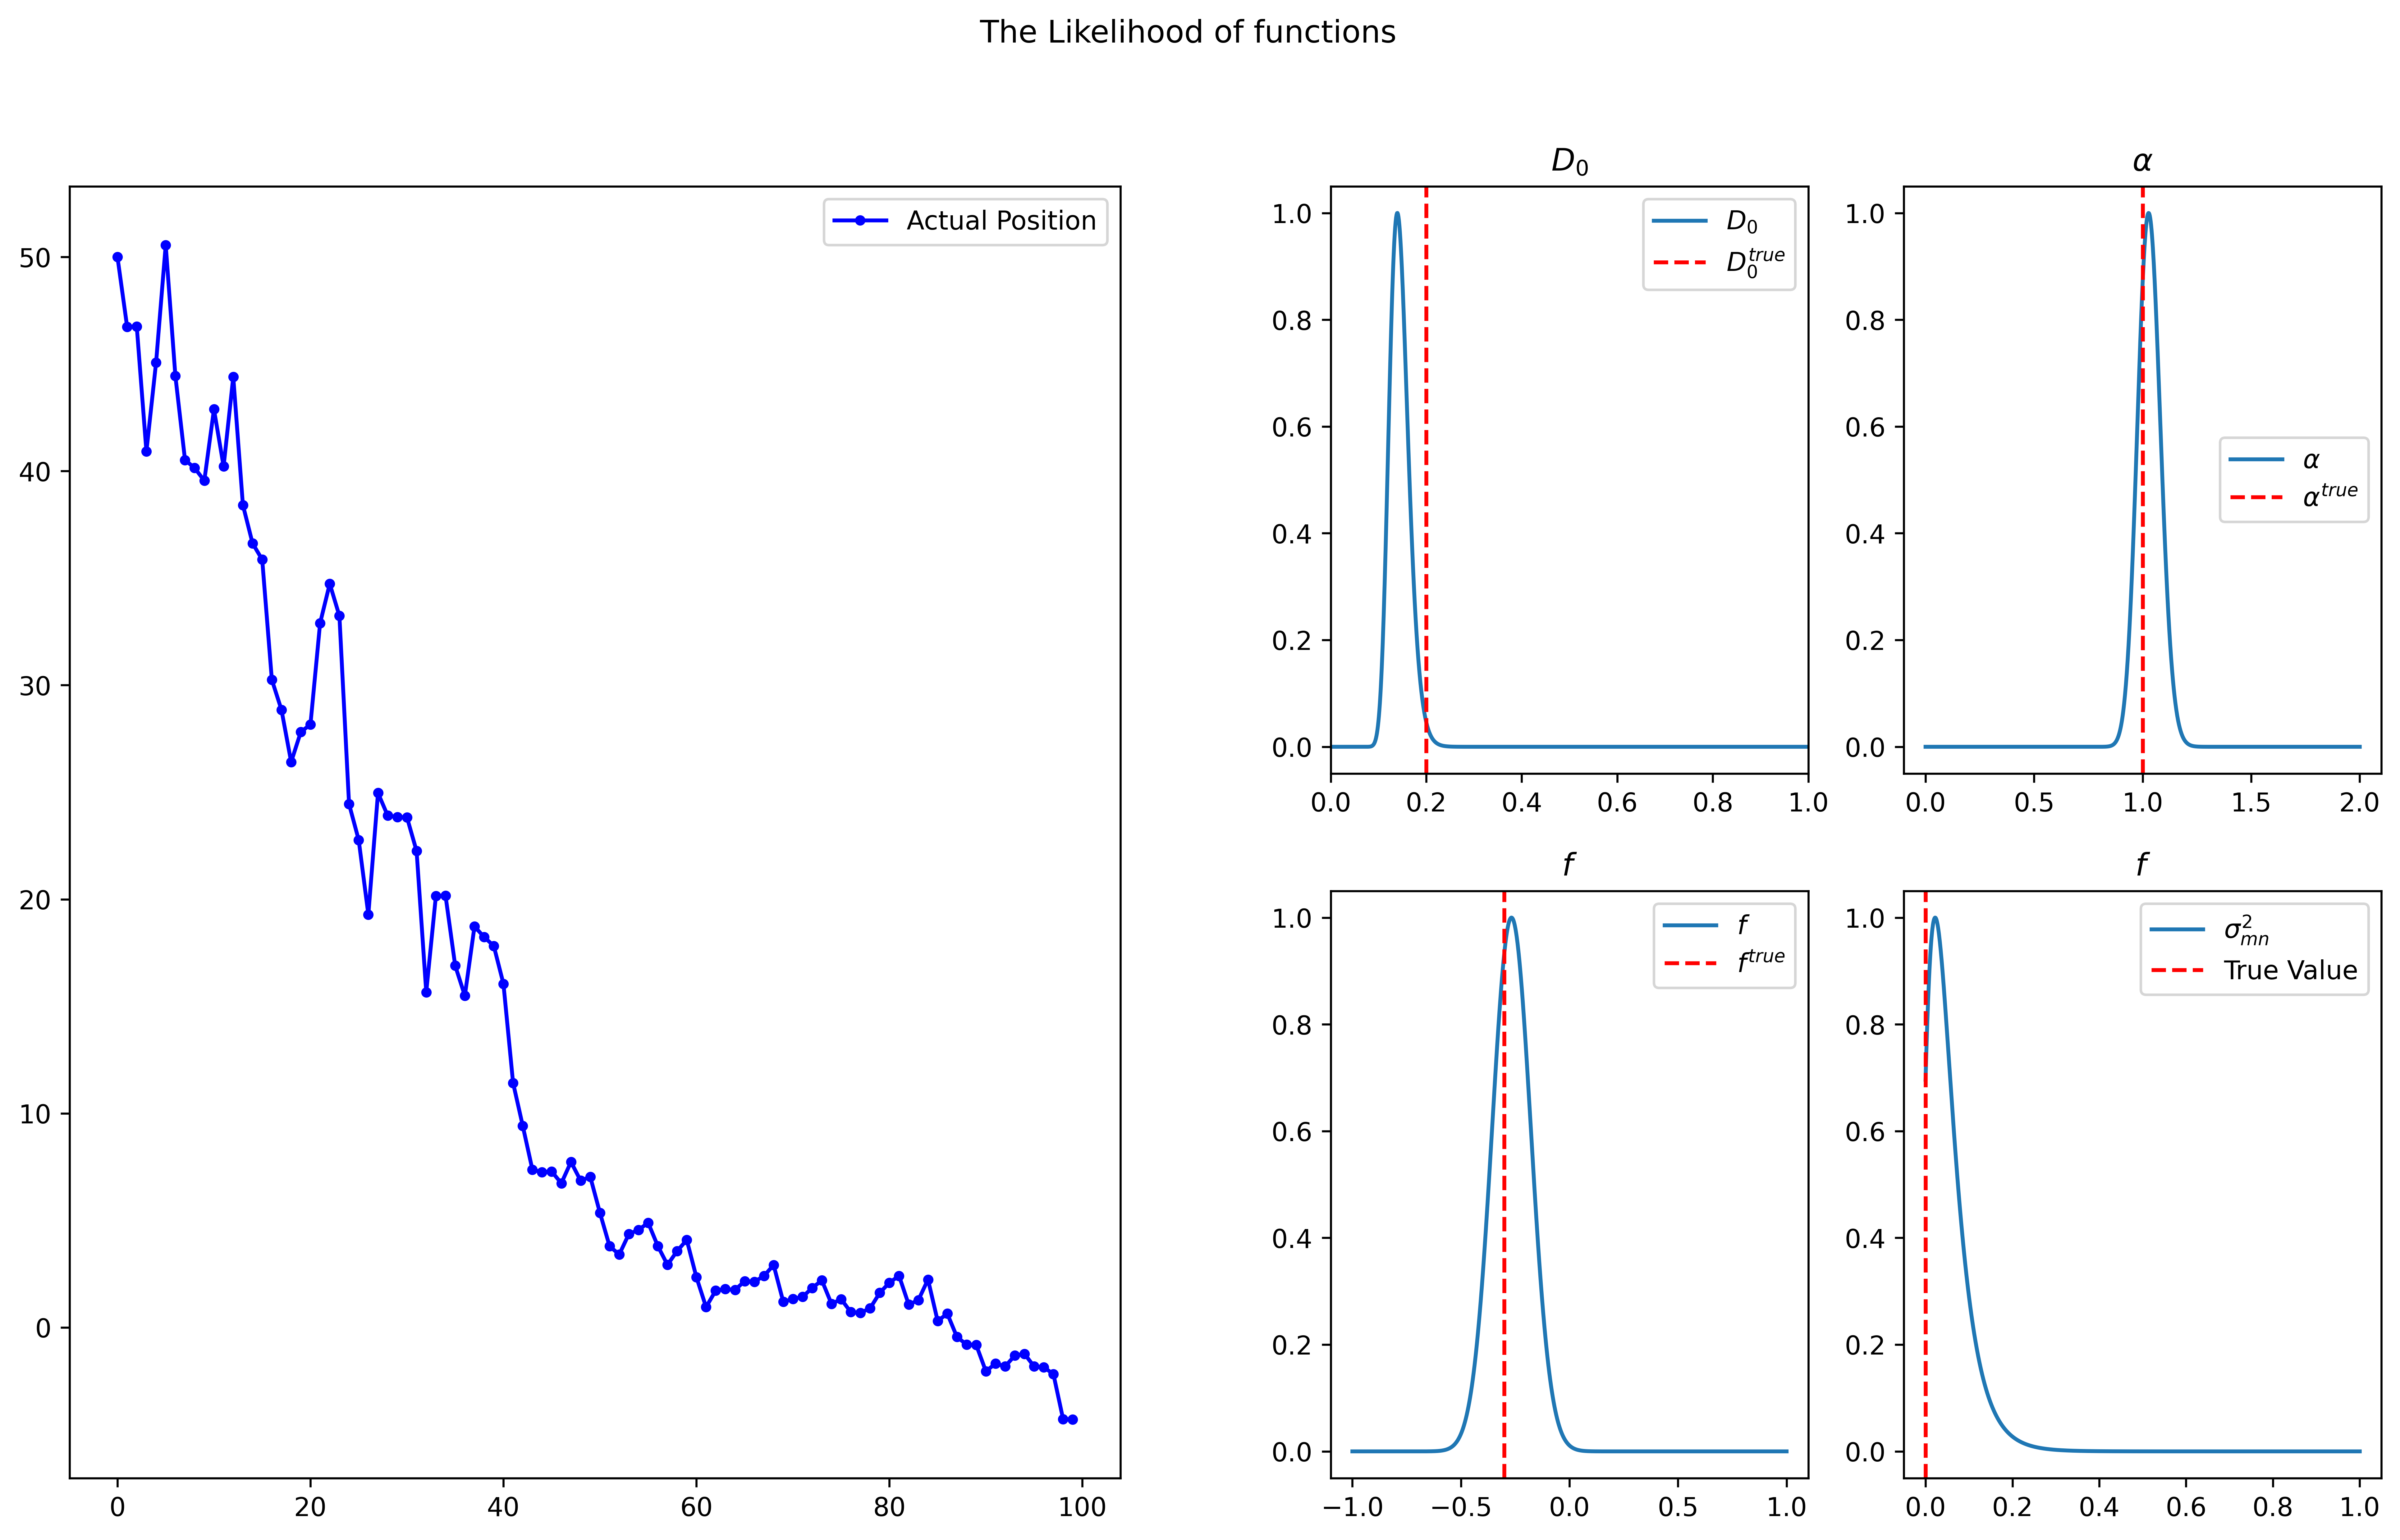

In [36]:
fig = plt.figure(figsize = (16,9), dpi = 600)

gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[:, :])

gs01 = gs0[1].subgridspec(2, 2)

ax2 = fig.add_subplot(gs01[:1, :1])
ax4 = fig.add_subplot(gs01[1, :1])

ax3 = fig.add_subplot(gs01[:1, -1])
ax5 = fig.add_subplot(gs01[-1,1 ])


# convert the loglikelihood to likelihood and normalize them
# the variable name might be confusing, ll is likelihood 
llA = np.exp(logPROBA - max(logPROBA))
llD = np.exp(logPROBD - max(logPROBD))
llF = np.exp(logPROBF - max(logPROBF))
llMN = np.exp(logPROBMN - max(logPROBMN))
# mllA = d_range[np.where(llA == 1)[0][0]]

plt.suptitle("The Likelihood of functions")

ax1.plot(t_clean_free, xmeasured,'.-b',label = r"Actual Position")
# ax1.plot(t_clean_free, xmeasured,'o--g',label = r"Measured Positions")
ax1.legend()

ax2.plot(d_range, llD, label = r"$D_0$")
ax2.axvline(x = D_0,ls ='--', color = 'r', label = r"$D_0^{true}$")
ax2.set_title(r"$D_0$")
ax2.set_xlim((0,1))
ax2.legend()

# axes[0][0].plot(d_range, np.exp(logPROBD1 - max(logPROBD1)), label = r"$\alpha$")

ax3.plot(alpha_range, llA, label = r"$\alpha$")
ax3.axvline(x = ALPHA_M,ls ='--', color = 'r', label = r"$\alpha^{true}$")
ax3.set_title(r"$\alpha$")
ax3.legend(loc = "right")

ax4.plot(F_L_range, llF, label = r"$f$")
ax4.axvline(x = F_L[1],ls ='--', color = 'r', label = r"$f^{true}$")
ax4.set_title(r"$f$")
ax4.legend()

ax5.plot(MN_range, llMN, label = r"$\sigma^2_{mn}$")
ax5.axvline(x = 0,ls ='--', color = 'r', label = "True Value")
ax5.set_title(r"$f$")
ax5.legend()

fig.savefig("ftrackpicKrog.png")

In [28]:
N = 1000
n = 100

# time step dt
DT = (t_e - t_0)/n

# log likelihood array initialization
logPROBD = np.zeros(N)
logPROBA = np.zeros(N)
logPROBF = np.zeros(N)
logPROBMN = np.zeros(N)

alpha_range = np.linspace(0, 2, N)
d_range=np.linspace(0.001,2,N)
F_L_range=np.linspace(-1,1,N)
MN_range = np.linspace(0, 10, N)

varmntemp = 2
ftemp = F_L[0]
t_clean_free,xmeasured1, xtrue = NoisyModel(n,t_e,ftemp,D_0,ALPHA_M,varmntemp)
# t_clean_free,xmeasured1 = Model(n,t_e,ftemp,D_0,ALPHA_M)



for i in range(0,N):
    # log likelihood for the applied force over a range of values    
    logPROBF[i] = noisylikelihoodcalc(xmeasured1,DT,D_0,F_L_range[i],ALPHA_M, varmntemp)

    # log likelihood for the applied force over a range of values    
    logPROBD[i] = noisylikelihoodcalc(xmeasured1,DT,d_range[i],ftemp,ALPHA_M, varmntemp)
    
    # log likelihood for the applied force over a range of values    
    logPROBA[i] = noisylikelihoodcalc(xmeasured1,DT,D_0,ftemp,alpha_range[i], varmntemp)

    # log likelihood for the applied force over a range of values    
    logPROBMN[i] = noisylikelihoodcalc(xmeasured1,DT,D_0,ftemp,ALPHA_M, MN_range[i])

In [29]:
x_data = np.zeros(100)
x_data = np.round(xmeasured1,3)
x_data

array([50.   , 48.557, 54.79 , 48.788, 46.448, 40.017, 40.331, 31.649,
       31.894, 34.673, 29.507, 32.508, 36.587, 39.429, 36.405, 32.027,
       40.127, 45.21 , 44.239, 39.576, 42.878, 44.231, 44.385, 49.384,
       51.068, 54.736, 49.167, 49.769, 50.97 , 49.785, 47.068, 47.699,
       50.221, 48.231, 44.357, 43.114, 33.031, 31.313, 29.413, 31.862,
       29.596, 32.715, 29.132, 29.939, 35.353, 34.022, 36.075, 33.694,
       38.878, 38.855, 38.448, 39.608, 38.644, 35.074, 42.625, 49.703,
       46.802, 42.722, 38.576, 38.432, 40.693, 29.152, 33.755, 34.921,
       37.439, 39.939, 49.231, 47.54 , 48.525, 57.005, 51.987, 57.069,
       52.112, 56.972, 56.477, 51.98 , 45.155, 46.742, 32.92 , 25.895,
       26.346, 30.46 , 22.018, 27.806, 30.262, 24.308, 27.504, 26.786,
       25.67 , 22.423, 22.034, 24.54 , 19.008, 17.428, 23.218, 18.881,
       21.009, 19.957, 27.875, 32.246])

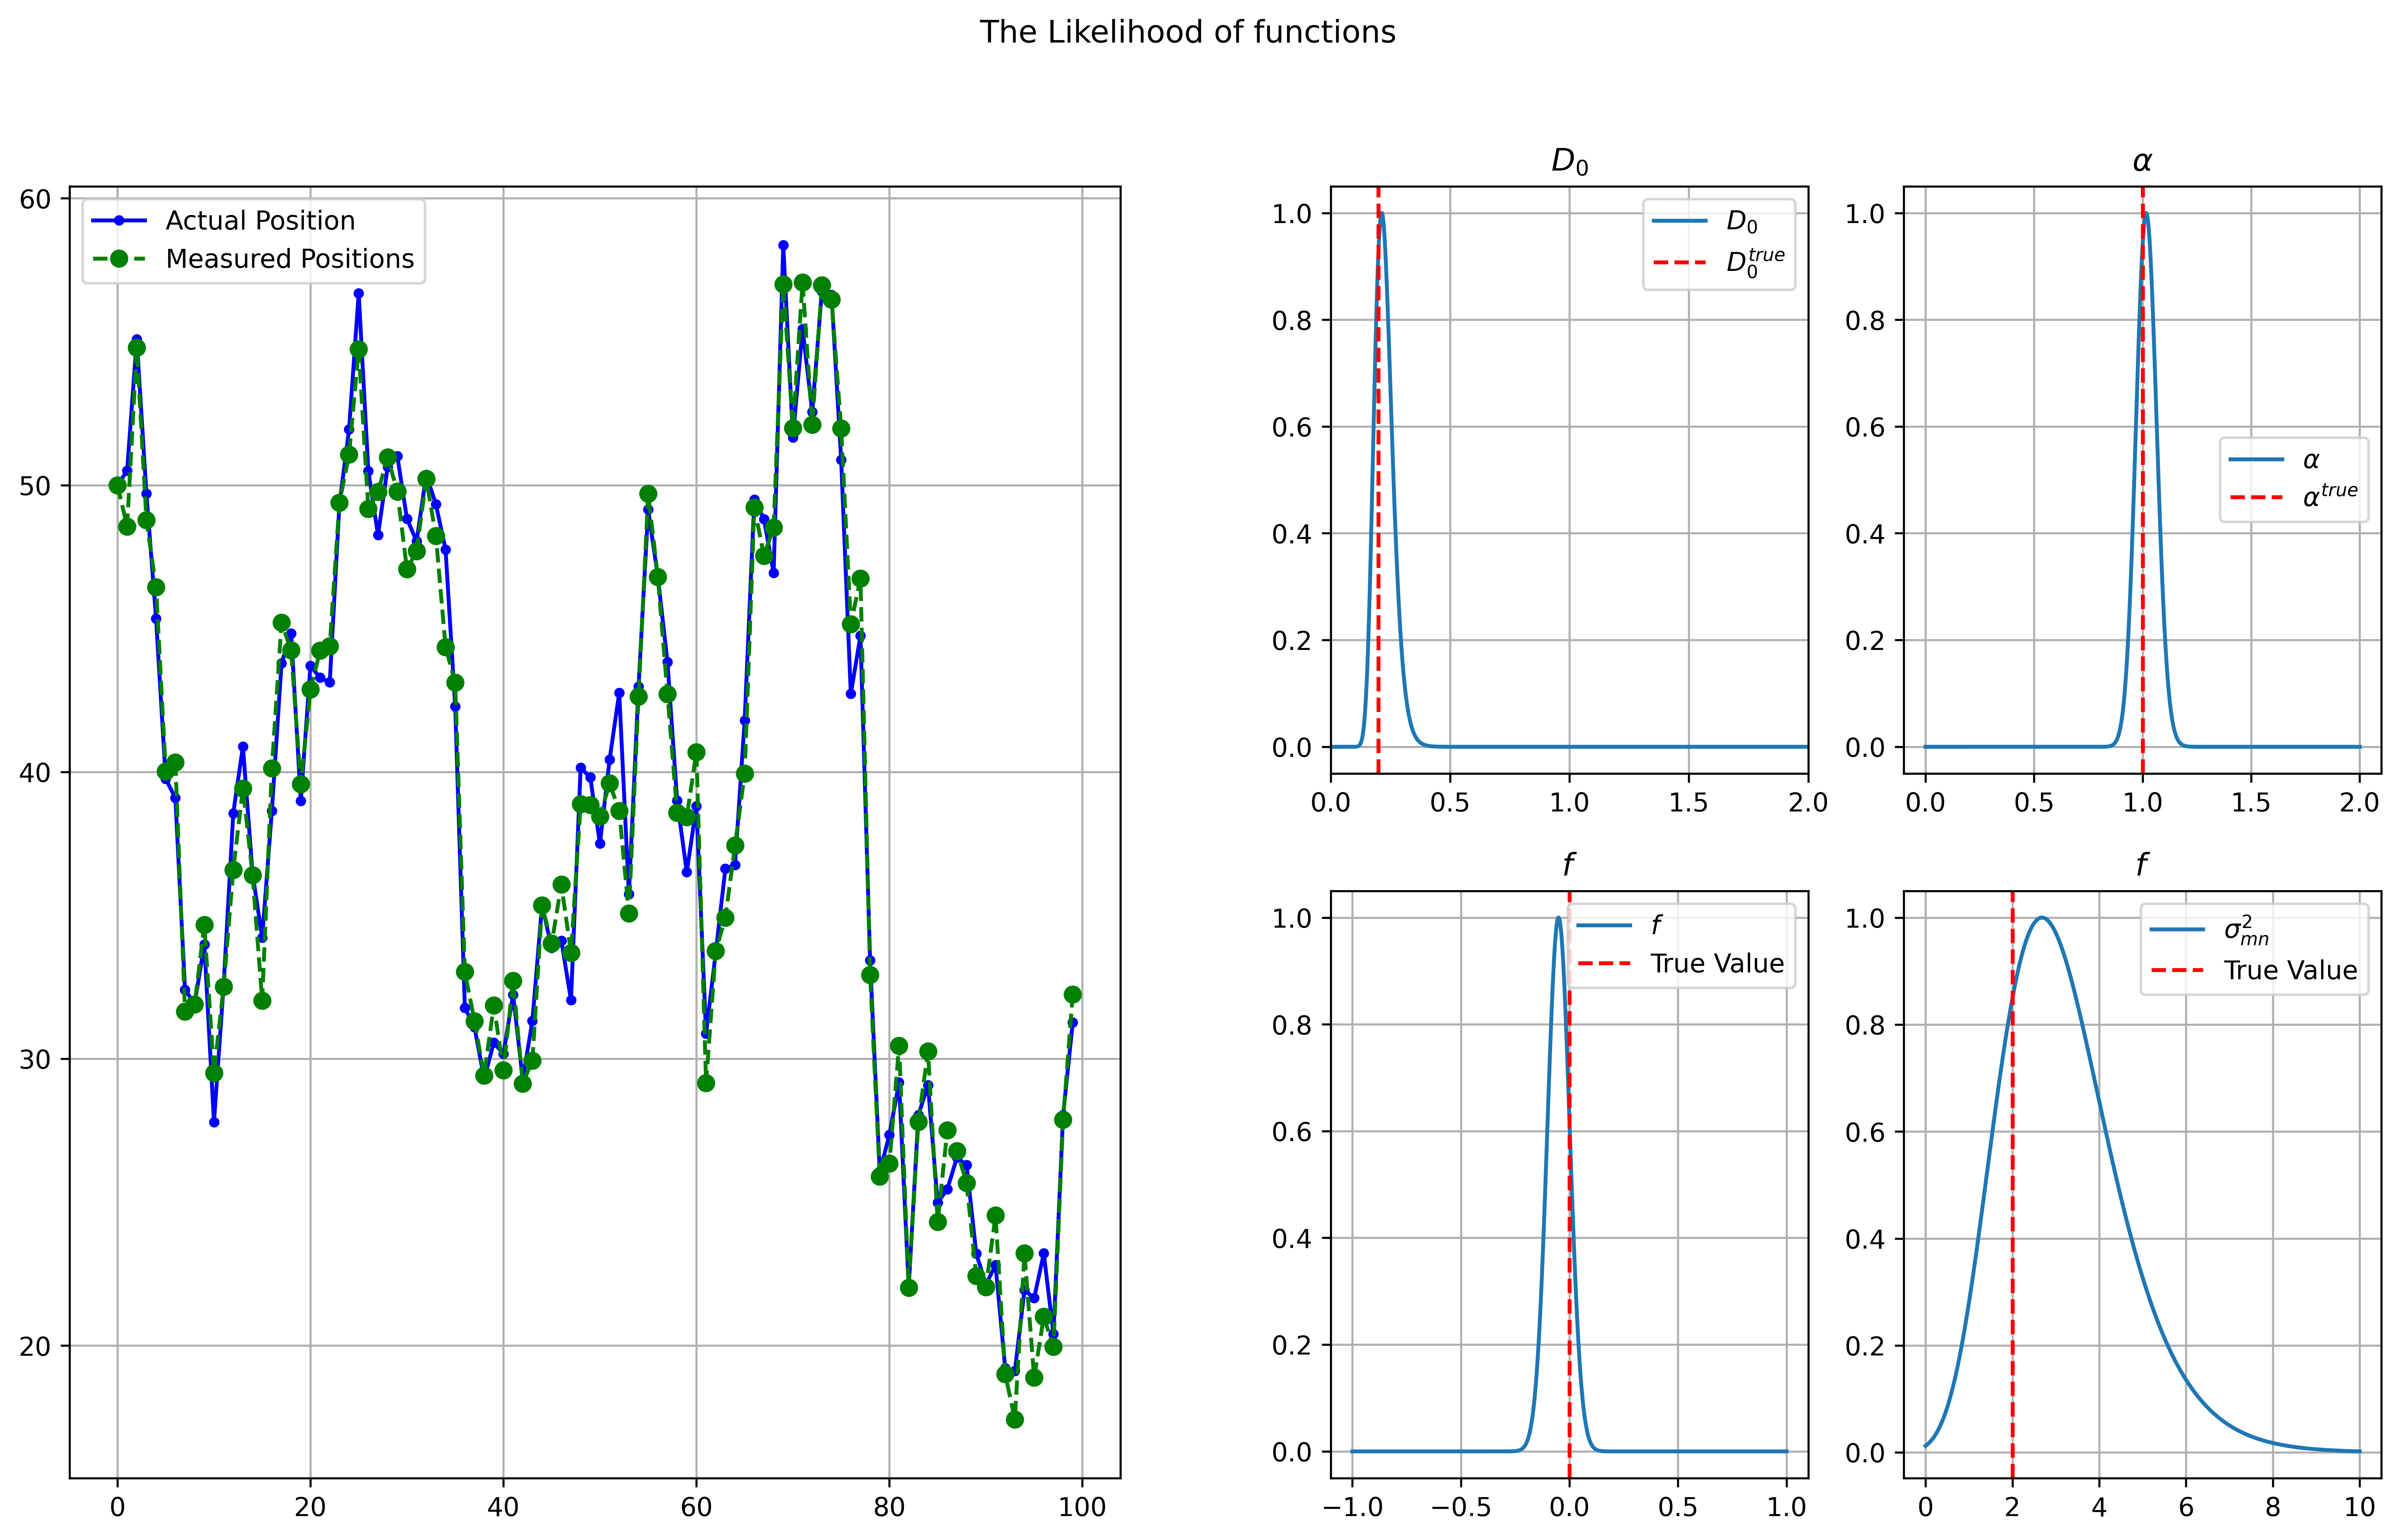

In [30]:
fig = plt.figure(figsize = (16,9), dpi = 600)

# Gridspec shit have to read later, boiler plate code from matplotlib docs
gs0 = gridspec.GridSpec(1, 2, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[:, :])
gs01 = gs0[1].subgridspec(2, 2)
ax2 = fig.add_subplot(gs01[:1, :1])
ax4 = fig.add_subplot(gs01[1, :1])
ax3 = fig.add_subplot(gs01[:1, -1])
ax5 = fig.add_subplot(gs01[-1,1 ])


# convert the loglikelihood to likelihood and normalize them
# the variable name might be confusing, ll is likelihood 
llA = np.exp(logPROBA - max(logPROBA))
llD = np.exp(logPROBD - max(logPROBD))
llF = np.exp(logPROBF - max(logPROBF))
llMN = np.exp(logPROBMN - max(logPROBMN))
# mllA = d_range[np.where(llA == 1)[0][0]]

plt.suptitle("The Likelihood of functions")

ax1.plot(t_clean_free, xtrue,'.-b',label = r"Actual Position")
ax1.plot(t_clean_free, xmeasured1,'o--g',label = r"Measured Positions")
ax1.grid()
ax1.legend()

ax2.plot(d_range, llD, label = r"$D_0$")
ax2.axvline(x = D_0,ls ='--', color = 'r', label = r"$D_0^{true}$")
ax2.set_title(r"$D_0$")
ax2.set_xlim((0,2))
ax2.grid()
ax2.legend()

# axes[0][0].plot(d_range, np.exp(logPROBD1 - max(logPROBD1)), label = r"$\alpha$")

ax3.plot(alpha_range, llA, label = r"$\alpha$")
ax3.axvline(x = ALPHA_M,ls ='--', color = 'r', label = r"$\alpha^{true}$")
ax3.set_title(r"$\alpha$")
ax3.grid()
ax3.legend(loc = "right")

ax4.plot(F_L_range, llF, label = r"$f$")
ax4.axvline(x = ftemp,ls ='--', color = 'r', label = "True Value")
ax4.set_title(r"$f$")
ax4.grid()
ax4.legend()

ax5.plot(MN_range, llMN, label = r"$\sigma^2_{mn}$")
ax5.axvline(x = varmntemp,ls ='--', color = 'r', label = "True Value")
ax5.set_title(r"$f$")
ax5.grid()
ax5.legend()

## Observations and Likelihood Calculations under Large Measurement noise

We can see that the maximum likelihood estimates for this particular can be seen with quite a large deivation due to the apparently large amount of measurement noise.

In [11]:
N = 1000
n = 100

# time step dt
DT = (t_e - t_0)/n

# log likelihood array initialization
logPROBD = np.zeros(N)
logPROBD1 = np.zeros(N)

logPROBA = np.zeros(N)
logPROBF = np.zeros(N)
logPROBMN = np.zeros(N)

alpha_range = np.linspace(0, 2, N)
d_range=np.linspace(0.001,5,N)
F_L_range=np.linspace(-1,1,N)
MN_range = np.linspace(0, 50, N)

varmntemp = 30
ftemp = F_L[1]
t_clean_free,xmeasured, xtrue = NoisyModel(n,t_e,ftemp,D_0,ALPHA_M,varmntemp)


for i in range(0,N):
    
    logPROBF[i] = noisylikelihoodcalc(xmeasured,DT,D_0,F_L_range[i],ALPHA_M, varmntemp)

    logPROBD[i] = noisylikelihoodcalc(xmeasured,DT,d_range[i],ftemp,ALPHA_M, varmntemp)

    # logPROBD1[i] = noisylikelihoodcalc(xtrue,DT,d_range[i],F_L[1],ALPHA_M, varmntemp)


    # logPROBD1[i] = SDE_logl_m(xmeasured,[d_range[i],ALPHA_M,F_L[1],varmntemp],1)

    
    logPROBA[i] = noisylikelihoodcalc(xmeasured,DT,D_0,ftemp,alpha_range[i], varmntemp)
    
    logPROBMN[i] = noisylikelihoodcalc(xmeasured,DT,D_0,ftemp,ALPHA_M, MN_range[i])

In [13]:
x_data = np.round(xmeasured,3)
x_t = np.round(xtrue,3)
print(",".join(str(e) for e in x_data))
print(",".join(str(e) for e in x_t))
print(",".join(str(e) for e in t_clean_free))

50.0,43.991,45.551,40.801,44.942,30.352,41.731,32.839,23.453,24.174,26.658,42.995,29.819,26.953,26.038,31.555,20.682,26.771,20.865,19.459,18.254,5.244,12.406,15.52,2.616,10.983,7.248,8.92,10.981,14.72,12.3,-3.495,14.211,-0.833,17.996,-2.37,11.819,-4.138,-1.815,1.192,13.561,-0.511,1.985,12.103,5.668,11.2,2.832,0.478,2.659,10.321,8.485,19.542,8.341,14.542,9.954,3.898,10.348,19.923,8.019,11.035,8.833,9.886,14.906,18.788,21.279,0.027,15.448,7.89,7.049,7.346,14.273,10.35,12.234,2.728,1.864,13.076,4.534,7.99,-0.475,18.191,7.939,5.779,11.756,11.783,10.857,10.053,3.289,8.427,5.459,1.758,2.532,6.595,6.17,3.953,0.396,7.238,2.782,12.005,2.24,5.32
50.0,45.439,41.854,47.473,41.123,32.771,32.738,30.643,27.686,30.542,35.337,35.453,27.37,22.701,27.14,28.004,27.167,24.252,19.938,16.23,13.946,14.425,14.182,12.04,9.999,9.23,9.008,9.263,11.093,10.901,7.988,5.055,5.024,6.092,6.879,5.183,4.366,2.393,3.372,4.219,6.009,7.71,8.923,8.809,5.643,3.518,4.411,4.462,4.94,4.908,6.775,10.276,11.263,10.242,9.659,8.873,

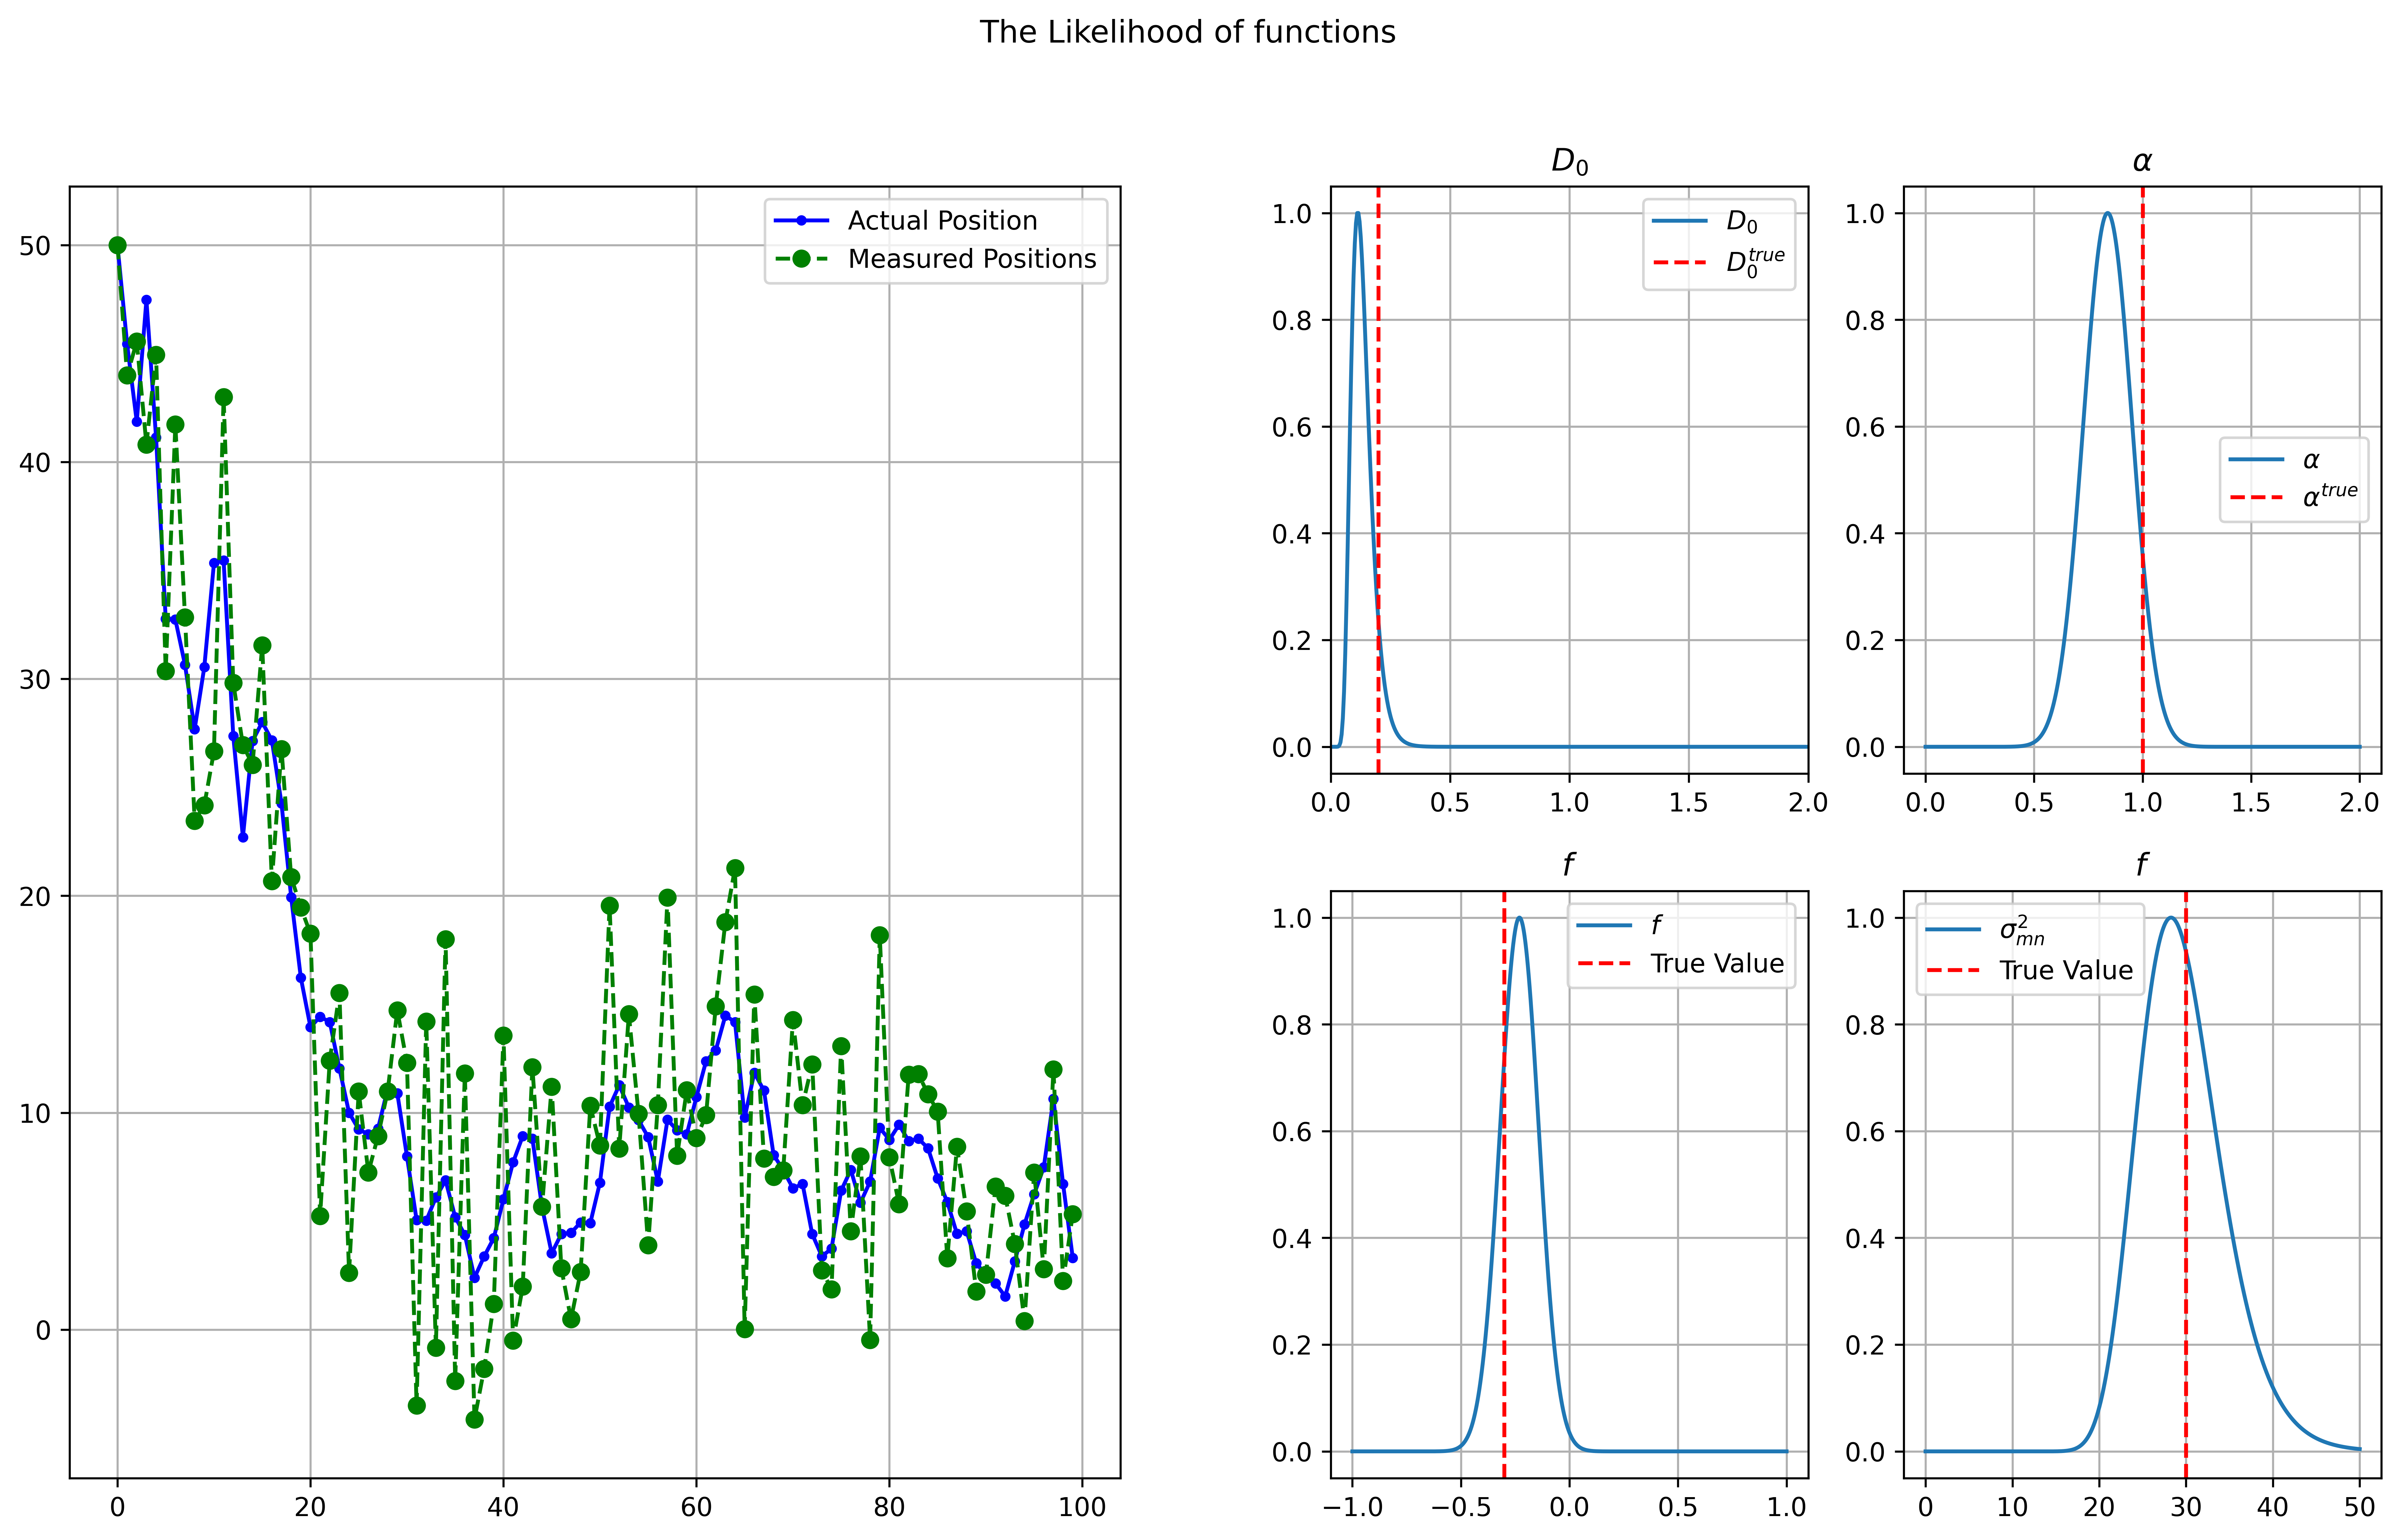

In [12]:
fig = plt.figure(figsize = (16,9), dpi = 600)

gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[:, :])

gs01 = gs0[1].subgridspec(2, 2)

ax2 = fig.add_subplot(gs01[:1, :1])
ax4 = fig.add_subplot(gs01[1, :1])

ax3 = fig.add_subplot(gs01[:1, -1])
ax5 = fig.add_subplot(gs01[-1,1 ])


# convert the loglikelihood to likelihood and normalize them
# the variable name might be confusing, ll is likelihood 
llA = np.exp(logPROBA - max(logPROBA))
llD = np.exp(logPROBD - max(logPROBD))
llF = np.exp(logPROBF - max(logPROBF))
llMN = np.exp(logPROBMN - max(logPROBMN))
# mllA = d_range[np.where(llA == 1)[0][0]]

plt.suptitle("The Likelihood of functions")

ax1.plot(t_clean_free, xtrue,'.-b',label = r"Actual Position")
ax1.plot(t_clean_free, xmeasured,'o--g',label = r"Measured Positions")
ax1.grid()
ax1.legend()

ax2.plot(d_range, llD, label = r"$D_0$")
ax2.axvline(x = D_0,ls ='--', color = 'r', label = r"$D_0^{true}$")
ax2.set_title(r"$D_0$")
ax2.set_xlim((0,2))
ax2.grid()
ax2.legend()

# axes[0][0].plot(d_range, np.exp(logPROBD1 - max(logPROBD1)), label = r"$\alpha$")

ax3.plot(alpha_range, llA, label = r"$\alpha$")
ax3.axvline(x = ALPHA_M,ls ='--', color = 'r', label = r"$\alpha^{true}$")
ax3.set_title(r"$\alpha$")
ax3.grid()
ax3.legend(loc = "right")

ax4.plot(F_L_range, llF, label = r"$f$")
ax4.axvline(x = ftemp,ls ='--', color = 'r', label = "True Value")
ax4.set_title(r"$f$")
ax4.grid()
ax4.legend()

ax5.plot(MN_range, llMN, label = r"$\sigma^2_{mn}$")
ax5.axvline(x = varmntemp,ls ='--', color = 'r', label = "True Value")
ax5.set_title(r"$f$")
ax5.grid()
ax5.legend()